In [1]:
import torch.nn as nn
import torch.nn.functional as F
from FCN8s_model import VGGNet,FCN8s
from deeplab_v3_plus import DeepLabV3P
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

In [2]:
# 定义预测函数
def predict(data,model):
    for road, road_msk in data:
        output = model(road)
        output = torch.sigmoid(output)
        output_np = output.detach().numpy().copy()
        output_np = np.argmax(output_np, axis=1)
        road_msk_np = road_msk.detach().numpy().copy()

        for road_single,road_msk_single,output_single in zip(road,road_msk_np,output_np):
            plt.figure()
            plt.subplot(131)
            plt.title('predict')
            plt.imshow(output_single)
            plt.subplot(132)
            plt.title('mask')
            plt.imshow(road_msk_single)
            plt.subplot(133)
            plt.title('ground_truth')
            plt.imshow(road_single.numpy().transpose(1, 2, 0))
            plt.show()
        break

In [3]:
# 利用torch提供的Dataset类，定义我们自己的数据集
import pandas as pd
data = pd.read_csv('imgpath.csv')
print(data.img_path[0])
print(data.mask_path[0])
class BagDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        img_name = data.img_path[idx]
        imgA = cv2.imread(img_name)
        imgA = cv2.resize(imgA, (640, 160))
        mask_name = data.mask_path[idx]
        imgB = cv2.imread(mask_name, 0)
        imgB = cv2.resize(imgB, (640, 160))
        imgB[imgB==76] = 1
        imgB[imgB>1] = 2
        imgB = imgB.astype('uint8')
        imgB = torch.FloatTensor(imgB)
        # print(imgB.shape)
        if self.transform:
            imgA = self.transform(imgA)
        return imgA, imgB


./data_road/training/image_2/umm_000000.png
./data_road/training/gt_image_2/umm_road_000000.png


In [4]:
# 归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.35,0.35,0.35], std=[0.30, 0.30, 0.30])])
# 加载数据
road = BagDataset(transform)
# test数量
train_size = int(0.9 * len(road))
test_size = len(road)-train_size
# 随机分配
_, test_dataset = random_split(road, [train_size, test_size])
# DataLoader加载
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


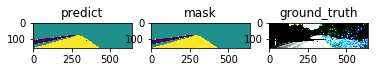

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


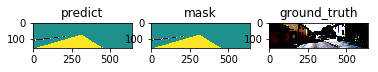

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


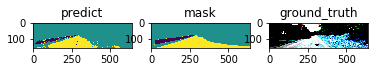

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


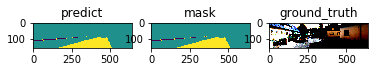

In [5]:
# 采用普通的交叉熵损失训练的预测结果,300个周期
vgg_model = VGGNet(requires_grad=False)
fcn_model_celoss = FCN8s(pretrained_net=vgg_model, n_class=3)
model_path_celoss ='./checkpoints/fcn_model_300.pth'
fcn_model_celoss.load_state_dict(torch.load(model_path_celoss))
predict(test_dataloader,fcn_model_celoss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


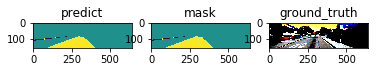

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


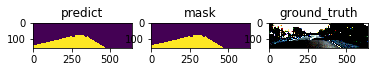

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


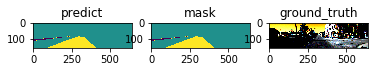

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


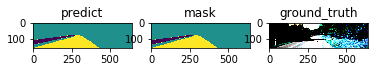

In [6]:
# 采用focalloss进行训练的预测结果
fcn_model_fcloss = FCN8s(pretrained_net=vgg_model, n_class=3)
model_path_fcloss = './checkpoints/fcn_model_Focalloss_100.pth'
fcn_model_fcloss.load_state_dict(torch.load(model_path_fcloss))
predict(test_dataloader,fcn_model_fcloss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


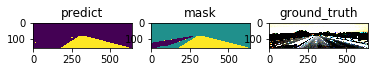

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


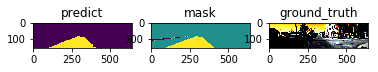

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


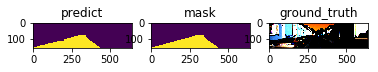

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


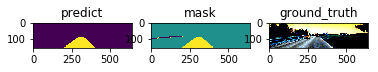

In [7]:
# 采用bcefocalloss进行二分类训练的预测结果
fcn_model_fcloss = FCN8s(pretrained_net=vgg_model, n_class=2)
model_path_fcloss = './checkpoints/fcn_model_BCEFocalloss_100.pth'
fcn_model_fcloss.load_state_dict(torch.load(model_path_fcloss))
predict(test_dataloader,fcn_model_fcloss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


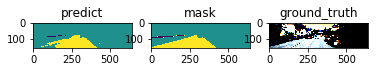

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


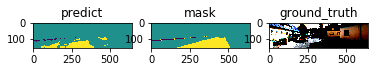

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


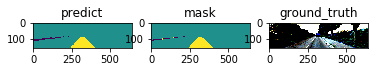

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


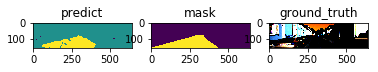

In [8]:
# 采用deeplabv3+训练的预测结果
model_fcloss =DeepLabV3P(3,3)
model_path_fcloss = './checkpoints/deeplabv3p_Focalloss_100.pth'
model_fcloss.load_state_dict(torch.load(model_path_fcloss))
predict(test_dataloader,model_fcloss)